<h1> Analytics Vidhya Competition: Loan approval prediction </h1>
<h3>
    <b>Author</b>: GHEZAIEL Morad<br>
    <b>Quality</b>: M.sc 2 Software development & Data Analysis<br>
    <b>Date</b>: 20/07/2020<br>
    <b>Current Rank</b>: 747 / 60930
    
</h3>

<h2> Introduction </h2><br>
In this competition, we are challenged to predict whether a loan applicant is eligible 
depending on several features such as: 
<ul>
    <li>Gender</li>
    <li>Marrital status</li>
    <li>Number of dependants</li>
    <li>Applicant and coapplicant income</li>
    <li>Loan amount</li>
    <li>Credit history</li>
    <li>...</li>
</ul>

<h2> Library loading </h2>

In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from itertools import combinations 
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from math import e

<h2> Data loading </h2>

In [2]:
train = pd.read_csv("/home/jaz/Bureau/AnalyticsVidhya/loanprediction/train.csv")
test = pd.read_csv("/home/jaz/Bureau/AnalyticsVidhya/loanprediction/test.csv")
sub = pd.read_csv("/home/jaz/Bureau/AnalyticsVidhya/loanprediction/sub.csv")

In [16]:
# Show the training dataset
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [17]:
# Show the test dataset
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [18]:
# Show the submission file
sub

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N
...,...,...
362,LP002971,N
363,LP002975,N
364,LP002980,N
365,LP002986,N


In [3]:
# Which columns differ between the train and the test datasets ? 
set(train.columns).difference(set(test.columns))


{'Loan_Status'}

In [4]:
# Check columns types
print("### Train \n:",train.dtypes,"\n")
print("### Test \n:",test.dtypes)

### Train 
: Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object 

### Test 
: Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object


In [237]:
# Count the number of NA Values in the training dataset. 
print("Training set: ",train.shape[0]-train.dropna().shape[0],"individuals with missing values.")
print("Testing set: ",test.shape[0]-test.dropna().shape[0],"individuals with missing values.")

Training set:  134 individuals with missing values.
Testing set:  78 individuals with missing values.


<h2> Data processing </h2>
We will manage to handle the missing values using the K nearest neighbors algorithm.<br>
Let's define a function to do so:

In [3]:
# We should consider an imputation approach
# We will impute using the nearest neighbors. 

def imputeData(df,n_neighbors=10): 
    
    # Store missing vectors
    to_impute = [idx for idx,i in enumerate(df.isna().values) if True in i]
    
    # digitized non numeric features
    digitized = df.copy().fillna(0)
    for feature in digitized.columns: 
        if digitized[feature].dtypes == object:
            dic = {i:idx for idx,i in enumerate(np.unique(digitized[feature].tolist())) }
            digitized[feature] = [dic[str(k)]for k in digitized[feature]]
            
    # Compute nearest neighbors and impute the missing value
    neighbors = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(digitized)
    distances, indices = neighbors.kneighbors(digitized)
    imputed = df.copy()
    for missing in to_impute: 
        nbrs = indices[missing]
        curr = df.iloc[missing,:].values
        for idx,val in enumerate(curr): 
            if val!=val:
                it = 1
                while imputed.iloc[missing,idx]!=imputed.iloc[missing,idx]:
                    neighbor = df.iloc[nbrs[it],idx]
                    imputed.iloc[missing,idx] = neighbor
                    it+=1
    return imputed 
                                             

We impute both the training and the test dataset. 

In [4]:
imputed_train = imputeData(train)
imputed_test = imputeData(test)

<h2> Data analysis </h2>
We will dig into the data. 
Especially, we'll try to answer two questions:
<ol>
    <li>Is the data, as it is, sufficient to predict the outcome ?</li>
    <li>Does non linear interaction between feature are critical to predict the outcome ?</li> 
</ol>
To do so, we will <b>perform principal component analysis (PCA)</b> on the original dataset.<br>
Evaluate clustering quality using a loan approval based <b>silhouette coefficient</b>.<br>
If its not sufficient, we will add <i>non linearity</i> to the dataset using <b>polynomial features</b>.<br>
Finally we will re-evaluate the clustering metric.<br>

In [5]:
# First, we have to digitized the data: 
train_imputed_digitized = imputed_train.copy()
for feature in train_imputed_digitized.columns: 
    if train_imputed_digitized[feature].dtypes == object:
        dic = {i:idx for idx,i in enumerate(np.unique(train_imputed_digitized[feature].tolist())) }
        train_imputed_digitized[feature] = [dic[str(k)]for k in train_imputed_digitized[feature]]



In [6]:
# Let's compute 3 principal components
pca = PCA(n_components = 3)
pcs = pca.fit_transform(train_imputed_digitized.filter([i for i in train.columns if i not in ["Loan_ID","Loan_Status"]]))

In [7]:
# Now, let's compute a silhouette coefficient: 
avg_silhouette = silhouette_score(pcs, imputed_train["Loan_Status"])

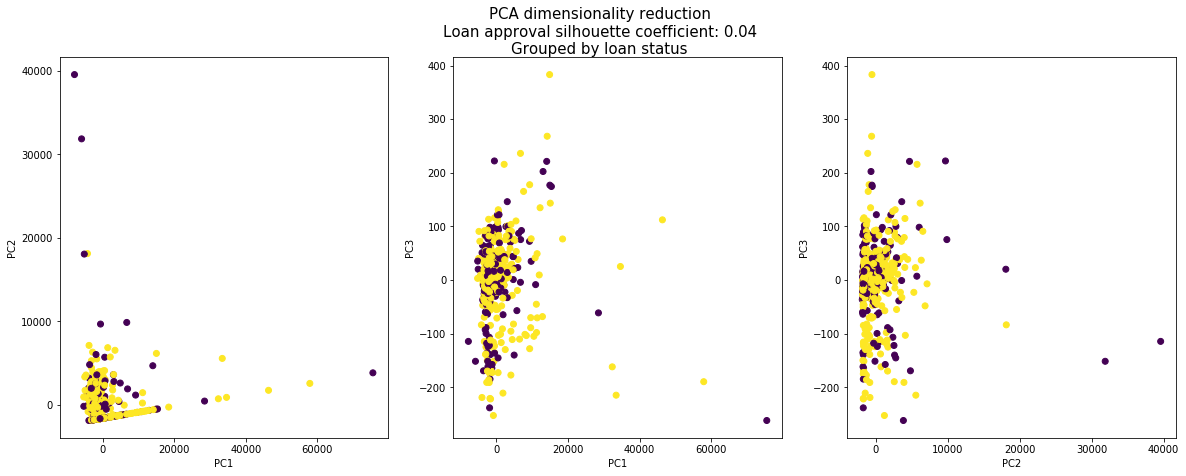

In [9]:
# Data visualization
f = plt.figure(figsize=(20,7))
index_pcs = [i for i in combinations([i for i in range(pcs.shape[1])],2)]

for idx,i in enumerate(index_pcs): 
    ax = f.add_subplot(100+(len(index_pcs)*10)+idx+1)
    ax.scatter([j[i[0]] for j in pcs],[j[i[1]] for j in pcs], c=train_imputed_digitized["Loan_Status"])
    ax.set_xlabel("PC{}".format(i[0]+1))
    ax.set_ylabel("PC{}".format(i[1]+1))

f.suptitle("PCA dimensionality reduction\nLoan approval silhouette coefficient: {}\nGrouped by loan status".format(round(avg_silhouette,3)),fontsize=15)
plt.show()

Clusters are fuzzy on the 3 first components.<br> 
Let's log transform the data:

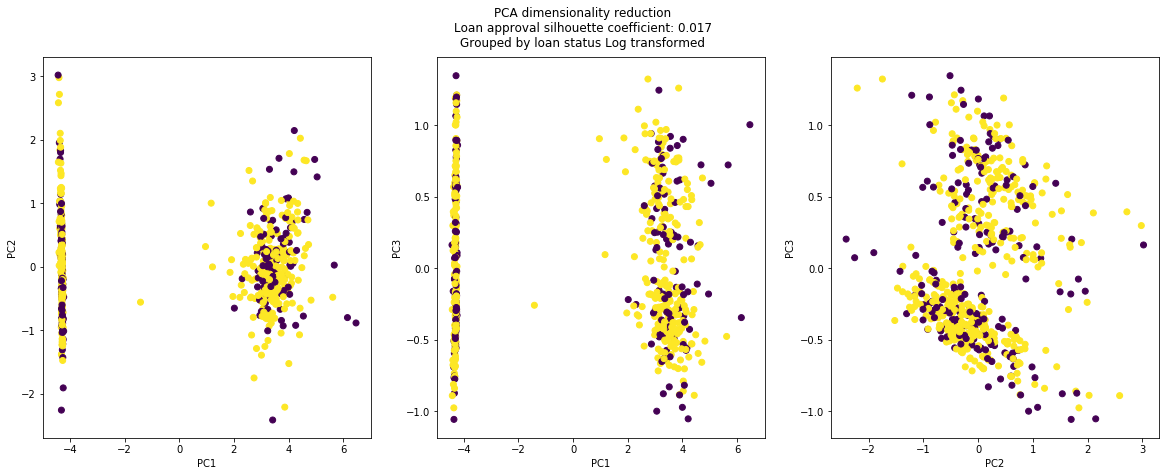

In [10]:
# What if we log transform the data ? 

# Let's compute 3 principal components
pca = PCA(n_components = 3)
pcs = pca.fit_transform(np.log(train_imputed_digitized.filter([i for i in train.columns if i not in ["Loan_ID","Loan_Status"]])+1))

# Now, let's compute a silhouette coefficient: 
avg_silhouette = silhouette_score(pcs, imputed_train["Loan_Status"])

# Data visualization
f = plt.figure(figsize=(20,7))
index_pcs = [i for i in combinations([i for i in range(pcs.shape[1])],2)]
for idx,i in enumerate(index_pcs): 
    ax = f.add_subplot(100+(len(index_pcs)*10)+idx+1)
    ax.scatter([j[i[0]] for j in pcs],[j[i[1]] for j in pcs], c=train_imputed_digitized["Loan_Status"])
    ax.set_xlabel("PC{}".format(i[0]+1))
    ax.set_ylabel("PC{}".format(i[1]+1))
    
f.suptitle("PCA dimensionality reduction\nLoan approval silhouette coefficient: {}\nGrouped by loan status Log transformed".format(round(avg_silhouette,3)),fontsize=12)
plt.show()

Clusters are less fuzzy.<br>
However the silhouette coefficient falled from 0.04 to 0.017.<br>
We can identify subpopulations but they are not associated to loan status.<br>
Let's investigate components loadings:

In [13]:
pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2','PC3'], 
             index=[i for i in train_imputed_digitized.columns 
             if i not in ["Loan_ID","Loan_Status"]])


,PC1,PC2,PC3
Gender,0.014740,0.085591,0.093110
Married,0.027048,0.124789,0.270737
Dependents,0.000778,0.246538,0.901217
Education,0.003304,-0.077005,0.091062
Self_Employed,-0.005831,0.061581,-0.000690
ApplicantIncome,-0.062335,0.761880,-0.208478
CoapplicantIncome,0.997384,0.033121,-0.019008
LoanAmount,0.017283,0.566063,-0.153434
Loan_Amount_Term,0.001917,0.012423,-0.094850
Credit_History,-0.000219,0.000835,-0.039365


As described by the above plots, subpopulations are driven by the first and the third components.<br>
Investigating the loadings reveal an implication of the marrital status for the first component.<br> 
But also an implication of the number of dependants for the third component.<br> 
Let's color the scatterplots accordingly.<br>

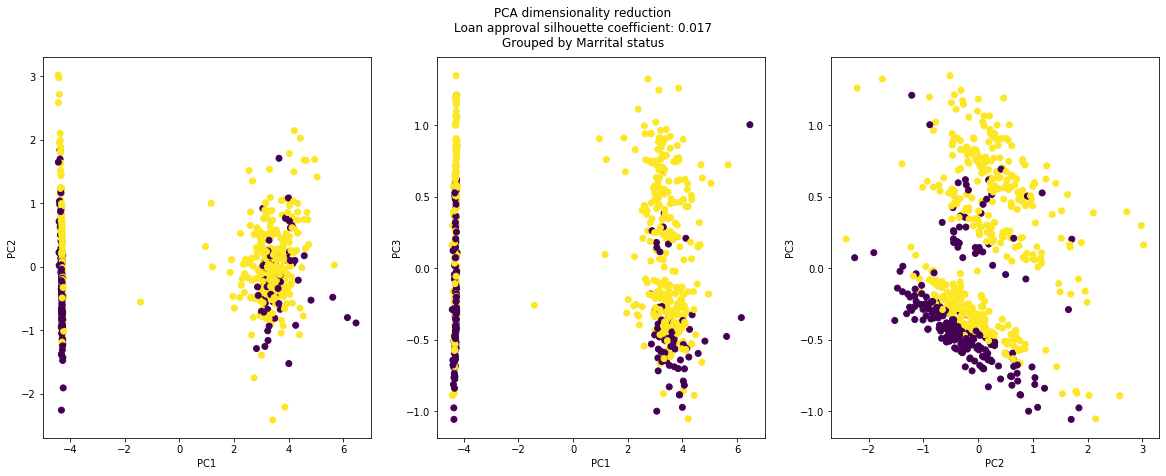

In [14]:
# Data visualization
f = plt.figure(figsize=(20,7))
index_pcs = [i for i in combinations([i for i in range(pcs.shape[1])],2)]
for idx,i in enumerate(index_pcs): 
    ax = f.add_subplot(100+(len(index_pcs)*10)+idx+1)
    ax.scatter([j[i[0]] for j in pcs],[j[i[1]] for j in pcs], c=train_imputed_digitized["Married"])
    ax.set_xlabel("PC{}".format(i[0]+1))
    ax.set_ylabel("PC{}".format(i[1]+1))
    
f.suptitle("PCA dimensionality reduction\nLoan approval silhouette coefficient: {}\nGrouped by Marrital status".format(round(avg_silhouette,3)),fontsize=12)
plt.show()

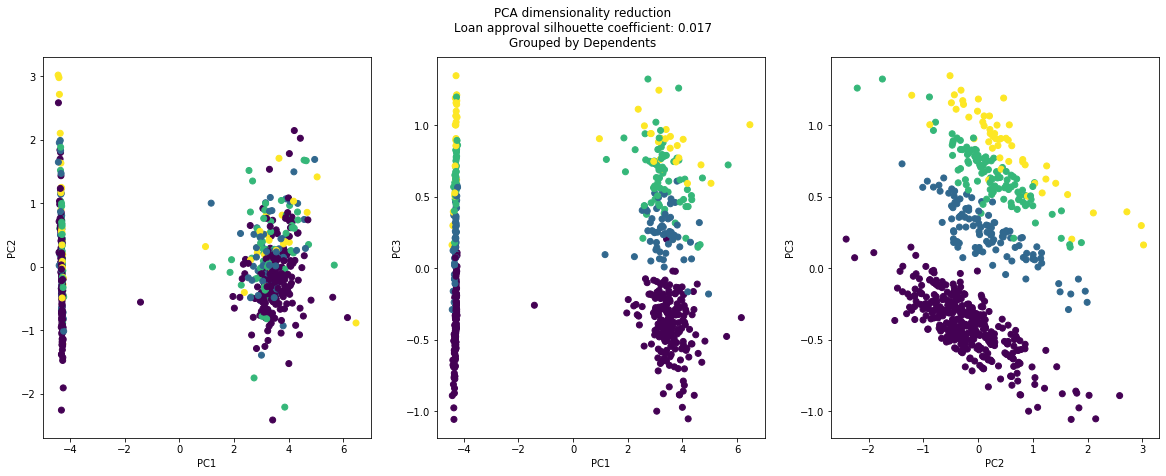

In [15]:
# Data visualization
f = plt.figure(figsize=(20,7))
index_pcs = [i for i in combinations([i for i in range(pcs.shape[1])],2)]
for idx,i in enumerate(index_pcs): 
    ax = f.add_subplot(100+(len(index_pcs)*10)+idx+1)
    ax.scatter([j[i[0]] for j in pcs],[j[i[1]] for j in pcs], c=train_imputed_digitized["Dependents"])
    ax.set_xlabel("PC{}".format(i[0]+1))
    ax.set_ylabel("PC{}".format(i[1]+1))
    
f.suptitle("PCA dimensionality reduction\nLoan approval silhouette coefficient: {}\nGrouped by Dependents".format(round(avg_silhouette,3)),fontsize=12)
plt.show()

Indeed, those features appears to be important to separate the data into subpopulations.<br>
However, these features are not really correlated with the loan status.<br><br>
In that way, we will add polynomial features to the dataset. 

In [16]:
train_imputed_digitized_log = np.log(train_imputed_digitized.filter([i for i in train.columns if i not in ["Loan_ID","Loan_Status"]])+1)
poly = PolynomialFeatures(4)
train_imputed_digitized_log_augmented = pd.DataFrame(poly.fit_transform(train_imputed_digitized_log))                                     

This done, let's take a look to how these features are correlated to the loan status.<br>
Especially, we will subset the data to feature with minimum 50% absolute correlation with the loan status. 

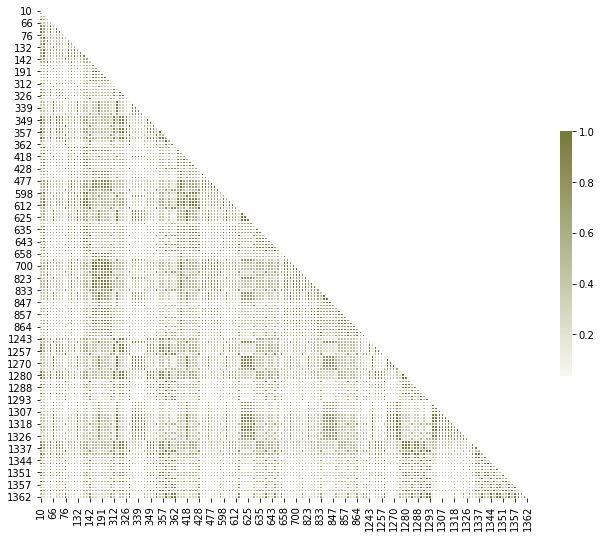

In [53]:

# Compute the correlation matrix
train_imputed_digitized_log_augmented["LOAN"] = train_imputed_digitized["Loan_Status"]
corr = train_imputed_digitized_log_augmented.corr()

# Subset to feature with minimum 10 % absolute correlation
FOI = [idx for idx,i in enumerate(corr.iloc[-1,:].values) if abs(i)>0.2]

# filter the dataset to interesting features
train_final = train_imputed_digitized_log_augmented.filter(FOI)

# Recompute correlation
corr = train_final.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(50, 90, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Filtering minimum 50% absolute correlation allowed us to fetch 10 features.
These 10 non linear features maximally correlate with the loan status (~98%).

Let's take a look to the shape of the data in PCA space. 

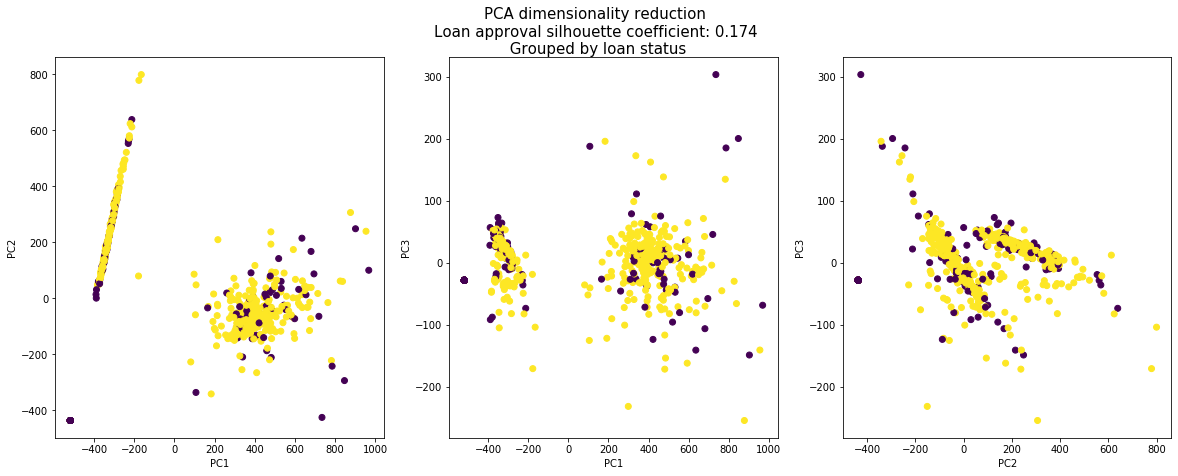

In [54]:
# Let's take a look to the data in PCA space 

# Let's compute 3 principal components
pca = PCA(n_components = 3)
pcs = pca.fit_transform(train_final)

# Now, let's compute a silhouette coefficient: 
avg_silhouette = silhouette_score(pcs, imputed_train["Loan_Status"])

# Data visualization
f = plt.figure(figsize=(20,7))
index_pcs = [i for i in combinations([i for i in range(pcs.shape[1])],2)]
for idx,i in enumerate(index_pcs): 
    ax = f.add_subplot(100+(len(index_pcs)*10)+idx+1)
    ax.scatter([j[i[0]] for j in pcs],[j[i[1]] for j in pcs], c=train_imputed_digitized["Loan_Status"])
    ax.set_xlabel("PC{}".format(i[0]+1))
    ax.set_ylabel("PC{}".format(i[1]+1))
    
f.suptitle("PCA dimensionality reduction\nLoan approval silhouette coefficient: {}\n Grouped by loan status".format(round(avg_silhouette,3)),fontsize=15)
plt.show()

Clusters in PCA are not very visible.<br>
However, the clustering metric has reached 0.174 (vs 0.017 previsouly).<br>
As log transformation increases overall distances, let's compute the square root of the data.

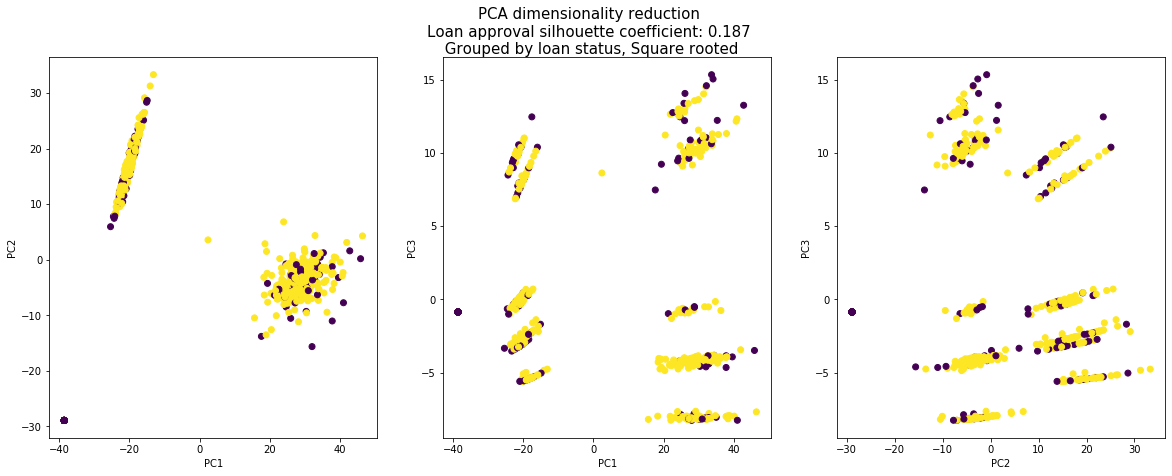

In [55]:
# Let's take a look to the data in PCA space 

# Let's compute 3 principal components
pca = PCA(n_components = 3)
pcs = pca.fit_transform(np.sqrt(train_final))

# Now, let's compute a silhouette coefficient: 
avg_silhouette = silhouette_score(pcs, imputed_train["Loan_Status"])

# Data visualization
f = plt.figure(figsize=(20,7))
index_pcs = [i for i in combinations([i for i in range(pcs.shape[1])],2)]
for idx,i in enumerate(index_pcs): 
    ax = f.add_subplot(100+(len(index_pcs)*10)+idx+1)
    ax.scatter([j[i[0]] for j in pcs],[j[i[1]] for j in pcs], c=train_imputed_digitized["Loan_Status"])
    ax.set_xlabel("PC{}".format(i[0]+1))
    ax.set_ylabel("PC{}".format(i[1]+1))
    
f.suptitle("PCA dimensionality reduction\nLoan approval silhouette coefficient: {}\n Grouped by loan status, Square rooted".format(round(avg_silhouette,3)),fontsize=15)
plt.show()

The silhouette coefficient has increased from 0.174 to 0.187.<br>
But the square root approach could be improved.<br> 
Indeed, arctangante provides a good shape.<br>
We will take it at a low power to decrease the slope (improve the variance).<br>
Datapoints will probably fall into subgroups.<br> 
This is interesting as we aim to use a random forest approach for predictions.<br>

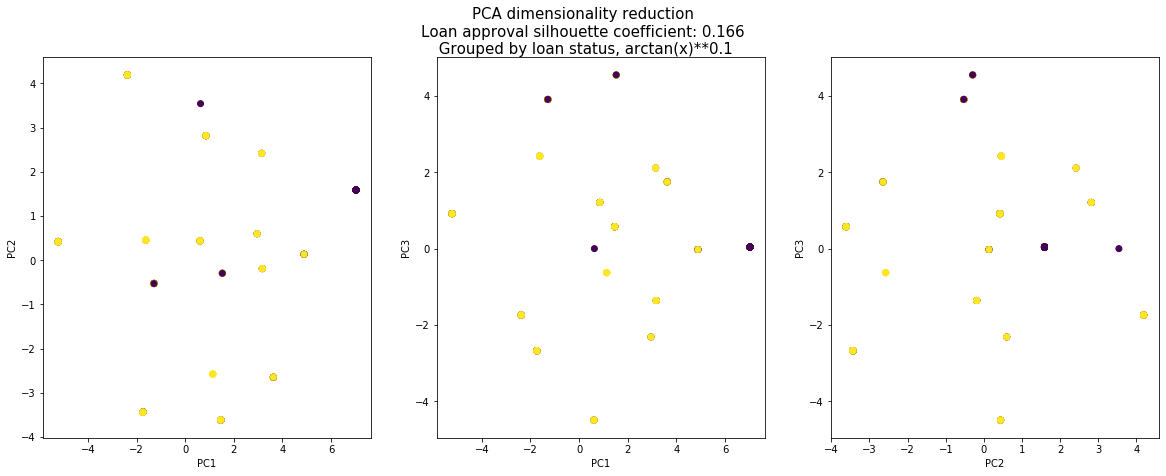

In [97]:
# Let's take a look to the data in PCA space 

# Let's compute 3 principal components
pca = PCA(n_components = 3)
pcs = pca.fit_transform((np.arctan(train_final)**0.1))

# Now, let's compute a silhouette coefficient: 
avg_silhouette = silhouette_score(pcs, imputed_train["Loan_Status"])

# Data visualization
f = plt.figure(figsize=(20,7))
index_pcs = [i for i in combinations([i for i in range(pcs.shape[1])],2)]
for idx,i in enumerate(index_pcs): 
    ax = f.add_subplot(100+(len(index_pcs)*10)+idx+1)
    ax.scatter([j[i[0]] for j in pcs],[j[i[1]] for j in pcs], c=train_imputed_digitized["Loan_Status"])
    ax.set_xlabel("PC{}".format(i[0]+1))
    ax.set_ylabel("PC{}".format(i[1]+1))
    
f.suptitle("PCA dimensionality reduction\nLoan approval silhouette coefficient: {}\n Grouped by loan status, arctan(x)**0.1".format(round(avg_silhouette,3)),fontsize=15)
plt.show()

This allowed us to reach a silhouette coefficient of 0.166.<br> 
It's less than before, but the datapoints are clustering in subpopulations. <br>
Let's prepare the test dataset.

In [98]:
# First, we have to digitized the data: 
test_imputed_digitized = imputed_test.copy()
for feature in test_imputed_digitized.columns: 
    if test_imputed_digitized[feature].dtypes == object:
        dic = {i:idx for idx,i in enumerate(np.unique(test_imputed_digitized[feature].tolist())) }
        test_imputed_digitized[feature] = [dic[str(k)]for k in test_imputed_digitized[feature]]
        
test_imputed_digitized_log = np.log(test_imputed_digitized.filter([i for i in test.columns if i not in ["Loan_ID","Loan_Status"]])+1)
poly = PolynomialFeatures(4)
test_imputed_digitized_log_augmented = pd.DataFrame(poly.fit_transform(test_imputed_digitized_log))   

# filter the dataset to interesting features
test_final = test_imputed_digitized_log_augmented.filter(FOI)

In [99]:
# Let's perform the same data transformation in the training and the testing sets. 
train_final = np.arctan(train_final)**0.1
test_final = np.arctan(test_final)**0.1

In [119]:
# Just make sure that training and testing sets have the same columns 
print(set(train_final.columns)) 
print(set(test_final.columns))

{357, 326, 360, 73, 10, 75, 1291, 1356, 1360, 61}
{357, 326, 360, 73, 10, 75, 1291, 1356, 1360, 61}


Let's train the random forest:

In [96]:

from sklearn.ensemble import RandomForestClassifier
label = train_imputed_digitized["Loan_Status"]
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.concat([train_final,test_final])
df_scaled = scaler.fit_transform(df)
df_train = df[:len(label)]
df_test = df[len(label):]
X_train, X_test, y_train, y_test = train_test_split(df_train, label, test_size=0.33, random_state=42)

weights = {0:1,1:0.8}

# Random forest without bootstrap to learn each subsamples.
model = RandomForestClassifier(max_depth=7,class_weight = weights,n_estimators=1000, bootstrap=False).fit(X_train,y_train)
print("Training F1 : {}".format(f1_score(y_train,model.predict(X_train), average='micro')))
print("Testing F1 : {}".format(f1_score(y_test,model.predict(X_test), average='micro')))
preds =model.predict(df_test)
print(len(preds),sub.shape)
dic = {0:"N",1:"Y"}
sub["Loan_Status"]=[dic[i] for i in preds]
sub.to_csv("Sub_completed_RF.csv",index=False)
print(sub)



Training F1 : 0.9367396593673966
Testing F1 : 0.7487684729064039
367 (367, 2)
      Loan_ID Loan_Status
0    LP001015           Y
1    LP001022           Y
2    LP001031           Y
3    LP001035           Y
4    LP001051           N
..        ...         ...
362  LP002971           Y
363  LP002975           Y
364  LP002980           N
365  LP002986           Y
366  LP002989           Y

[367 rows x 2 columns]


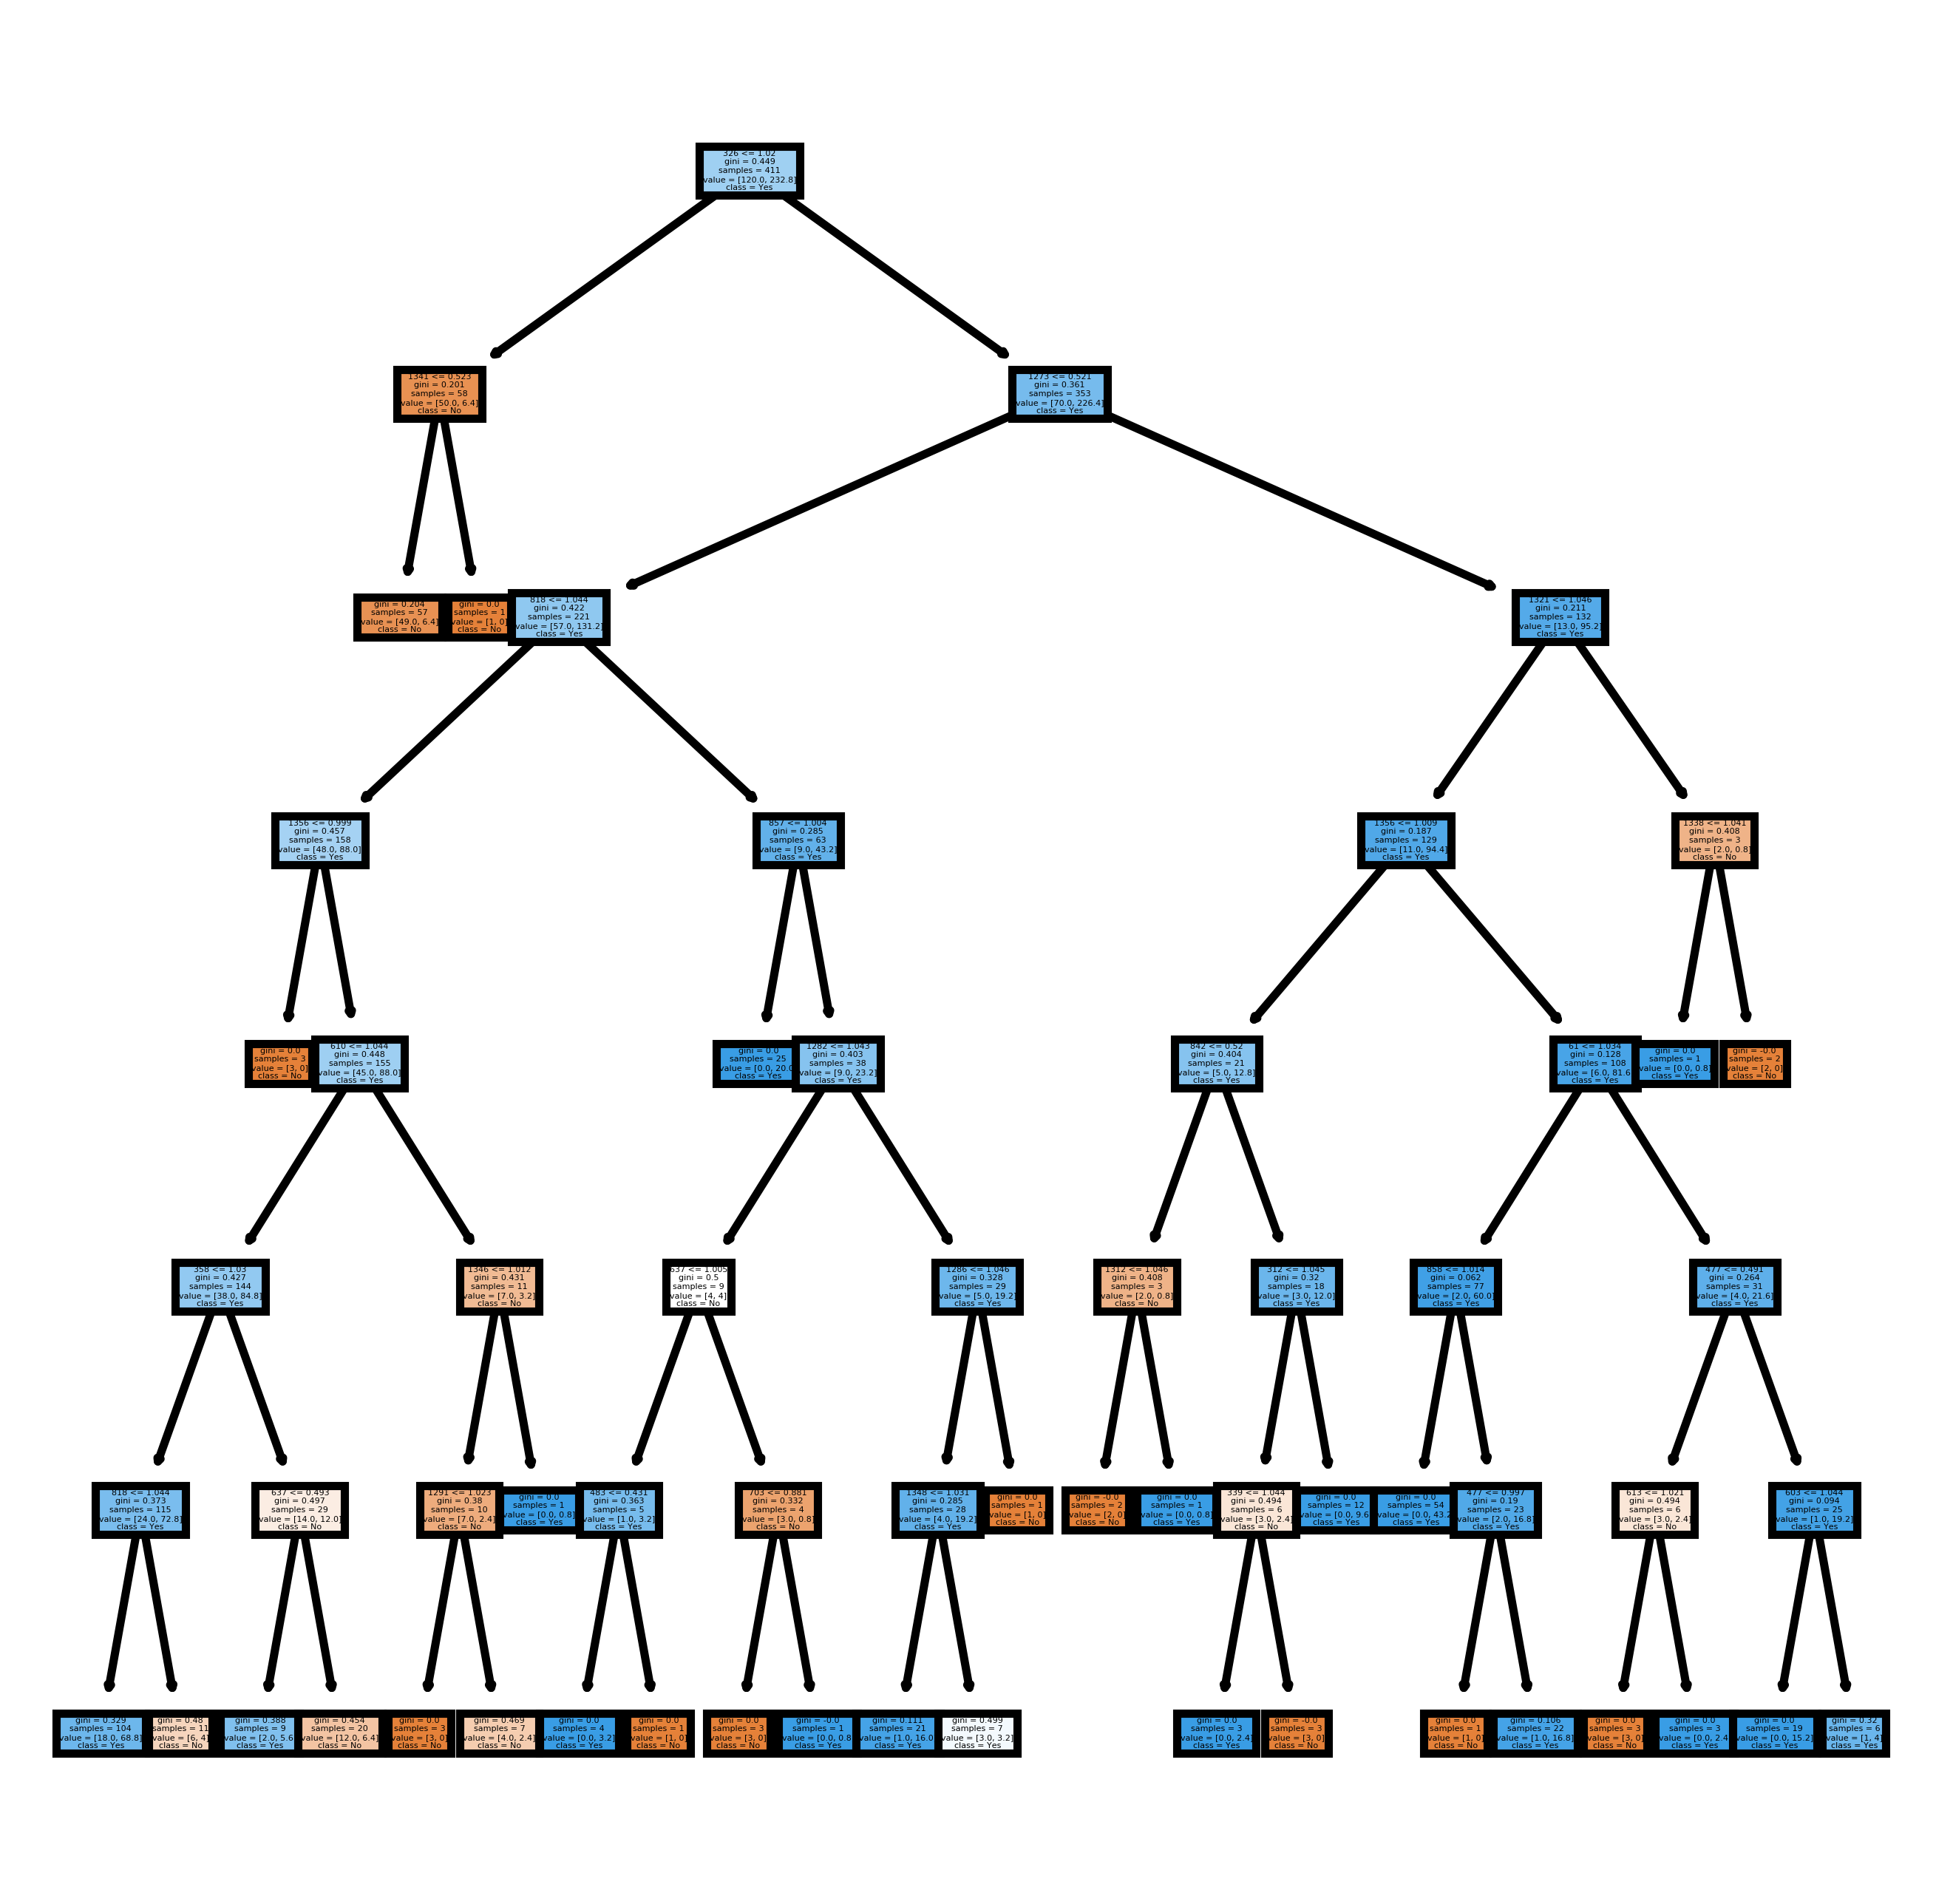

In [95]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf.estimators_[0],
               feature_names = test_final.columns, 
               class_names=["Yes" if i ==0 else "No" for i in label],
               filled = True);
fig.savefig('tree.png')


Finally, the overall approach could be improve by considering higher level feature engineering.<br>
We could for example apply individual transformation for each features.<br>
In addition, we do not have perform any outlier detection step.<br>
It could be easily performed then compared to the standard approach.<br> 

# Thanks for your attention ! 